In [1]:
from tensorflow.keras.applications.resnet import preprocess_input 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

### Loading the names and labels csv file

In [2]:
train_df = pd.read_csv('../input/dog-breed-identification/labels.csv')

### Retaining only the required 10 breeds

In [3]:
train_df = train_df.loc[(train_df.breed == 'beagle') | (train_df.breed == 'doberman') | (train_df.breed == 'chihuahua') | (train_df.breed == 'french_bulldog') | (train_df.breed == 'golden_retriever') | (train_df.breed == 'malamute') | (train_df.breed == 'pug') | (train_df.breed == 'saint_bernard') | (train_df.breed == 'scottish_deerhound') | (train_df.breed == 'tibetan_mastiff')].reset_index(drop=True)

In [4]:
train_df

,id,breed
0,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
1,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
2,008b1271ed1addaccf93783b39deab45,doberman
3,00a366d4b4a9bbb6c8a63126697b7656,golden_retriever
4,0100f55e4f0fe28f2c0465d3fc4b9897,golden_retriever
...,...,...
836,fe50bac6c389d137ea01c9cfc7346ca8,scottish_deerhound
837,fe624532170510bd80627c0500bafc97,tibetan_mastiff
838,feb16cf86c9dac6d476e3c372ba5c279,pug
839,febcab8eb2da444bf83336cffec7eb92,golden_retriever


### Numbers of images per category of dog breeds

In [5]:
train_df.breed.value_counts()

scottish_deerhound    126
beagle                105
pug                    94
saint_bernard          84
malamute               81
doberman               74
chihuahua              71
french_bulldog         70
tibetan_mastiff        69
golden_retriever       67
Name: breed, dtype: int64

### Creating path for each image, for helper function to decode the image.

In [6]:
train_paths = '../input/dog-breed-identification/train/' + train_df['id'] + '.jpg'

### Getting the lables into one-hot encoding format

In [7]:
labels = pd.get_dummies(train_df.breed).values

In [8]:
column_names = pd.get_dummies(train_df.breed).columns.to_list()

### Spliting the data into train and test purpose.

In [9]:
train_path, valid_path, train_labels, valid_labels = train_test_split(train_paths, labels, test_size=0.3, random_state=42)

## Creating dataset with the tf.data API for faster computational speed

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((train_path, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_path, valid_labels))

### Helper function that will that the path and return tf.float32 dtype tensors of the image.

In [11]:
def decode_train_data(image_path, label):
    
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img,[312,312])
    
    return img, label

### Mapping the helper function for decoding with num_parallel_calls=AUTOTUNE to do multiple operations parallelly. 

In [12]:
train_ds = train_ds.map(decode_train_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.map(decode_train_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

### Data augmentation is really helpful when we are dealing with low number of train samples. It creates more samples from already exiting samples by tweaking little information in it.

In [13]:
def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    return img, label

### Also a helper fuction which has many utilities like caching for faster data retrival, batching the train samples in a set of 16, shuffling the data for true randomness and prefectching the data for the model, so the delivery of next set of sample batch wouldn't become the bottleneck in the architecture.

In [14]:
def configure_for_performance(ds, batch_size = 16):
    
    ds = ds.cache('/kaggle/dump.tfcache')
    ds = ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.repeat()
    ds = ds.shuffle(buffer_size=25)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

In [15]:
train_ds_batch = configure_for_performance(train_ds)
valid_ds_batch = valid_ds.batch(32)

### First we instantiates the ResNet50 architecture as base model with 'ImageNet' weights as default and we set layers of the model as trainable

In [16]:
base_model = tf.keras.applications.ResNet50(include_top=False,weights="imagenet")
for layers in base_model.layers:
    layers.trainable=True

94773248/94765736 [==============================] - 1s 0us/step


### We are creating our transfer learning model with base layer as the ResNet50 layer. We added the data augmentation in the model as it will happen parallelly in CPU while the CNN will train in GPU. While using the ResNet50, Keras expects a specific kind of input preprocessing, we have to pass the inputs through the Preprocess_input for better processing. Then it passes through few other layers and finally at last dense layers, we set the no. of unique labels for prediction with softmax activation


### After defining the model, we add optimizers, loss funtion and metrics for evaluation fo the model. Here we used Adam with a learning rate of 3e-4 and loss function as Categorical_crossentropy as we have categorical labels.

In [17]:
def build_model():
    inputs = tf.keras.layers.Input(shape=(312, 312, 3))
    preprocess = preprocess_input(inputs)
    outputs_resnet = base_model(preprocess)
    global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()(outputs_resnet)
    dense_1= tf.keras.layers.Dense(256, kernel_regularizer = 'l2')(global_avg_pooling)
    bn_1 = tf.keras.layers.BatchNormalization()(dense_1)
    activation = tf.keras.layers.Activation('relu')(bn_1)
    dropout = tf.keras.layers.Dropout(0.35)(activation)
    dense_2 = tf.keras.layers.Dense(10, activation='softmax')(dropout)
    
    
    model = tf.keras.Model(inputs, dense_2)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr = 3e-4),
        loss='categorical_crossentropy',
        metrics='acc'
    )
    
    return model

### Initialize the model and check it Summary.

In [18]:
model = build_model()

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 312, 312, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 312, 312, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 312, 312, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024  

### Here we define callbacks for our model. This include saving the Modelcheckpoint, which monitor the validation loss to reduce the learning rate if it sees that the model is not improving for 4 epochs and also saves the model with lowest validation loss.

In [19]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    './model.h5', save_best_only=True, monitor='val_loss', mode='min')
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", patience=4, min_lr=1e-5, mode='min')

### Here we set the epochs and steps_per_epoch(no. of samples/batch_size) and then start traing our model.

In [20]:
steps_per_epoch = len(train_paths) // 16
epochs = 40
history = model.fit(
                train_ds_batch, 
                validation_data = valid_ds_batch, 
                epochs = epochs,
                callbacks=[checkpoint, lr_reducer],
                steps_per_epoch = steps_per_epoch
)

Epoch 1/40
52/52 [==============================] - 23s 263ms/step - loss: 6.8831 - acc: 0.2553 - val_loss: 6.8576 - val_acc: 0.0988
Epoch 2/40
52/52 [==============================] - 11s 207ms/step - loss: 5.7045 - acc: 0.5376 - val_loss: 7.1571 - val_acc: 0.1225
Epoch 3/40
52/52 [==============================] - 10s 200ms/step - loss: 4.7955 - acc: 0.7353 - val_loss: 6.4535 - val_acc: 0.1581
Epoch 4/40
52/52 [==============================] - 11s 204ms/step - loss: 4.1130 - acc: 0.8523 - val_loss: 5.9481 - val_acc: 0.0711
Epoch 5/40
52/52 [==============================] - 10s 198ms/step - loss: 3.8452 - acc: 0.8140 - val_loss: 6.8700 - val_acc: 0.0672
Epoch 6/40
52/52 [==============================] - 10s 202ms/step - loss: 3.3996 - acc: 0.8689 - val_loss: 5.6392 - val_acc: 0.0988
Epoch 7/40
52/52 [==============================] - 10s 200ms/step - loss: 2.8863 - acc: 0.9258 - val_loss: 5.8699 - val_acc: 0.1067
Epoch 8/40
52/52 [==============================] - 11s 203ms/step - 

### Graph plot of Accurarcy and loss of the model during the training.

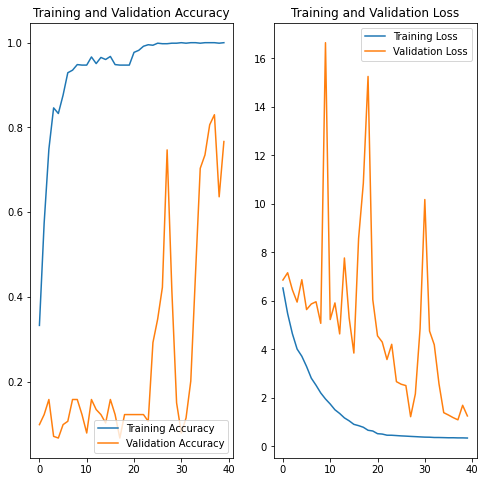

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()